In [877]:
import os
import math
import numpy as np
import cantera as ct
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

In [878]:
# reaction_mechanism_name, fuel = 'LiDryer', 'H2:1.0'
reaction_mechanism_name, fuel = 'chempolimi_edit', 'NH3:1.0'
reaction_mechanism = f'../mechanisms/{reaction_mechanism_name}.yaml'

gas = ct.Solution(reaction_mechanism)
gas.transport_model='Mix'

In [879]:
# Define mixture and integration data
phi= 1.0
#p  = 1.0   # atm
p  = 10 # atm
T0 = 1100   # K

tFinal = 1  # s
dt     = 1e-4  # s

tign=1.3970e-01 s, Tign= 1747.148 K

1747.1481211306211K 0.13970000000000093
tAfterIgn = 2.000e-02 s,   timeStep= 1597 


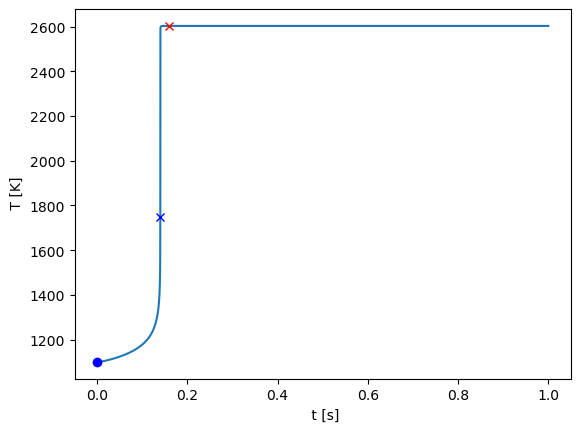

In [880]:
from ruamel.yaml import YAML, scalarstring
yaml=YAML()
yaml.default_flow_style = False

# Initial condition --------------------------------------------------------
gas.set_equivalence_ratio(phi, fuel , 'O2:0.21, N2:0.79')
gas.TP = T0, p*ct.one_atm
#print(gas.species_names)
P = gas.P

# Integrate the constant pressure homogeneous reactor ----------------------
r   = ct.IdealGasConstPressureReactor(gas)
sim = ct.ReactorNet([r])

nst = 0
time = 0.0
tt = []     # time [s]
TT = []     # temperature [K]
XX = []     # mole fractions
YY = []     # mass fractions

tt.append(time)
TT.append(T0)
XX.append(gas.X)
YY.append(gas.Y)

while time<tFinal:
    time = time + dt
    sim.advance(time) # CVODE
    tt.append(time)   # time [s]
    TT.append(r.T)    # temperature [K]
    YY.append(r.Y)    # mass fractions
    gas.Y = r.Y
    XX.append(gas.X)  # mole fractions
    nst = nst + 1

# State 1: Initial state to test initiation reactions ------------------------
with open(f'{reaction_mechanism_name}.initial', 'w') as f: 
# with open(f'{reaction_mechanism_name}.initial.highP', 'w') as f: 
    yaml.dump({
    'temperature': TT[0], 
    'pressure':    gas.P, 
    'X': dict(zip([scalarstring.DoubleQuotedScalarString(name) for name in gas.species_names], XX[0].tolist()))
}, f)


# State 2: Ignition ----------------------------------------------------------

f      = UnivariateSpline(tt[:nst], TT[:nst])
dTdt   = f.derivative()           # dT/dt
ignStep = np.argmax(dTdt(tt))
ignTime = tt[ignStep]
Tign    = TT[ignStep]
print('tign=%.4e s, Tign= %.3f K\n' % (ignTime, Tign) )
print(f'{Tign:=}K {ignTime:=}')

with open(f'{reaction_mechanism_name}.ignition', 'w') as f: 
# with open(f'{reaction_mechanism_name}.ignition.highP', 'w') as f: 
    yaml.dump({
    'temperature': Tign,
    'pressure': gas.P,
    'X': dict(zip([scalarstring.DoubleQuotedScalarString(name) for name in gas.species_names],XX[ignStep].tolist()))
}, f)
    
    
# State 3: post ignition ----------------------------------------------------

tAfterIgn = 20e-3
stepAfterIgn = min( int((ignTime + tAfterIgn)/dt), int(tFinal/dt) )
print('tAfterIgn = %.3e s,   timeStep= %d ' % (tAfterIgn, stepAfterIgn) )

with open(f'{reaction_mechanism_name}.final', 'w') as f: 
# with open(f'{reaction_mechanism_name}.final.highP', 'w') as f: 
    yaml.dump({
    'temperature': TT[stepAfterIgn], 
    'pressure': gas.P, 
    'X': dict(zip([scalarstring.DoubleQuotedScalarString(name) for name in gas.species_names],XX[stepAfterIgn].tolist()))
}, f)

# visual check
plt.plot(tt, TT, '-')
plt.plot(tt[0], TT[0], 'bo')
plt.plot(tt[ignStep], TT[ignStep], 'bx')
plt.plot(tt[stepAfterIgn], TT[stepAfterIgn], 'rx')
plt.xlabel(' t [s]')
plt.ylabel(' T [K]')
plt.show()


In [881]:
# thermodynamic properties
cp = []   # [J/kmol/K]
Hk = []

gas.TPX = T0, P, XX[0]
cp.append(gas.partial_molar_cp)
Hk.append(gas.partial_molar_enthalpies)

gas.TPX = TT[ignStep], P, XX[ignStep]
cp.append(gas.partial_molar_cp)
Hk.append(gas.partial_molar_enthalpies)

gas.TPX = TT[stepAfterIgn], P, XX[stepAfterIgn]
cp.append(gas.partial_molar_cp)
Hk.append(gas.partial_molar_enthalpies)

print("----cp [J/kmol/K]----")
for name in gas.species_names: 
    idx = gas.species_index(name)
    print('%-15s  %+.15e  %+.15e  %+.15e' % (name, cp[0][idx], \
                                                   cp[1][idx], \
                                                   cp[2][idx]) )
print("----Hk [J/kmol] ----")    
for name in gas.species_names: 
    idx = gas.species_index(name)
    print('%-15s  %+.15e  %+.15e  %+.15e' % (name, Hk[0][idx], \
                                                   Hk[1][idx], \
                                                   Hk[2][idx]) )

----cp [J/kmol/K]----
H                +2.078613480252880e+04  +2.078626848199554e+04  +2.078618505107714e+04
H2               +3.060812686205289e+04  +3.331720735269193e+04  +3.603689945145506e+04
H2NN             +6.334603939831748e+04  +7.311343886176326e+04  +7.849593800286576e+04
H2NO             +6.354128526934143e+04  +7.239929332558697e+04  +7.778362460404990e+04
H2O              +4.259012319451944e+04  +4.932002290364978e+04  +5.480663850575760e+04
H2O2             +6.470839454197631e+04  +7.296905910537537e+04  +7.908805796412159e+04
HNO              +4.944946701379139e+04  +5.872740482973064e+04  +6.607756339643760e+04
HNO2             +6.853994995303774e+04  +7.600235398309035e+04  +7.993234308508060e+04
HNOH             +6.386477317901774e+04  +7.240678469915505e+04  +7.770336673167069e+04
HO2              +4.932909791218235e+04  +5.535454074058672e+04  +6.060489257134191e+04
HONO             +7.064871080816592e+04  +7.656269650377824e+04  +7.995184350109573e+04
HONO2     

In [882]:
#  species net production rates 
netProdRates = []
rxnRates = []

gas.TPX = T0, P, XX[0]
netProdRates.append(gas.net_production_rates)
rxnRates.append(gas.net_rates_of_progress)

gas.TPX = TT[ignStep], P, XX[ignStep]
netProdRates.append(gas.net_production_rates)
rxnRates.append(gas.net_rates_of_progress)

gas.TPX = TT[stepAfterIgn], P, XX[stepAfterIgn]
netProdRates.append(gas.net_production_rates)
rxnRates.append(gas.net_rates_of_progress)

for name in gas.species_names: 
    idx = gas.species_index(name)
    print('%-15s  %+.15e  %+.15e  %+.15e' % (name, netProdRates[0][idx], \
                                                   netProdRates[1][idx], \
                                                   netProdRates[2][idx]) )

H                +5.915799257451293e-09  +4.621763388486585e-02  +1.336949957415933e-11
H2               +0.000000000000000e+00  +6.986670513179666e+00  -6.852016047569045e-11
H2NN             +0.000000000000000e+00  +4.670950842281883e-03  +7.614077884128516e-23
H2NO             +0.000000000000000e+00  +1.460118988941253e-02  -1.508701429738187e-17
H2O              +0.000000000000000e+00  +4.122044290674236e+01  +4.607407683986732e-11
H2O2             +0.000000000000000e+00  -7.165853270130890e-05  -8.053672155938112e-14
HNO              +0.000000000000000e+00  +3.398107009765947e-02  -2.055874455399608e-14
HNO2             +0.000000000000000e+00  -1.234070652001552e-06  -4.198539466031294e-16
HNOH             +0.000000000000000e+00  +4.836654157308747e-03  -2.094015956294963e-17
HO2              +5.383987073948174e-04  +2.106459462095774e-02  -1.404199202476437e-13
HONO             +0.000000000000000e+00  -1.208063227726230e-04  -1.586897619418488e-14
HONO2            +0.000000000000

In [883]:
# individual reaction rates
for ir in range(gas.n_reactions): 
    print('%3d   %-35s  %+.15e  %+.15e  %+.15e' % (ir, gas.reaction_equation(ir), \
                                                 rxnRates[0][ir], \
                                                 rxnRates[1][ir], \
                                                 rxnRates[2][ir]) )


  0   H2 + M <=> 2 H + M                   +0.000000000000000e+00  -1.046450592710932e-04  -2.628823714267980e-09
  1   H2 + O <=> H + OH                    +0.000000000000000e+00  +1.460122336969629e+00  -1.164150376098405e-07
  2   H2 + OH <=> H + H2O                  +0.000000000000000e+00  +9.038326687943474e-01  -6.910204319865443e-08
  3   2 O + M <=> O2 + M                   -2.552042390996876e-14  +1.039224992295533e-05  +1.521486773375935e-10
  4   H + O2 <=> O + OH                    +0.000000000000000e+00  +1.348122831200516e+01  +6.025835830314463e-08
  5   H + OH + M <=> H2O + M               +0.000000000000000e+00  +3.026827315677661e-03  +1.579644202109876e-07
  6   H2O + O <=> 2 OH                     +0.000000000000000e+00  +2.134053361705918e+00  -2.690961764528765e-07
  7   H + O + M <=> OH + M                 +0.000000000000000e+00  +5.349283243751695e-04  +7.806274737731655e-09
  8   H2O2 (+M) <=> 2 OH (+M)              +0.000000000000000e+00  +6.748509458812979e-0

/tmp/ipykernel_5186/894877694.py:3: DeprecationWarning: 'reaction_equation' is deprecated and will be removed after Cantera 2.6.
Replaceable by property 'equation' of the corresponding reaction object.
  print('%3d   %-35s  %+.15e  %+.15e  %+.15e' % (ir, gas.reaction_equation(ir), \


In [884]:
# transport properties
gas.TPX = T0, P, XX[0]
print('cond =', gas.thermal_conductivity)
print('visc =', gas.viscosity)
print('rho*diff =', gas.density*gas.mix_diff_coeffs_mole)

cond = 0.09113422378377817
visc = 4.406235763038132e-05
rho*diff = [3.42066081e-04 2.05614357e-04 5.53698334e-05 5.70309034e-05
 7.28034888e-05 5.72421800e-05 5.74465125e-05 5.01370642e-05
 5.70309034e-05 5.76215605e-05 5.01370642e-05 4.59326658e-05
 7.90471178e-05 6.17361841e-05 5.53698334e-05 4.87874715e-05
 4.42191647e-05 4.56163192e-05 9.37056850e-05 9.16989599e-05
 5.66377790e-05 6.75665153e-05 5.58159132e-05 5.66492207e-05
 5.03338507e-05 4.60427652e-05 8.89221074e-05 5.84465336e-05
 8.72756076e-05 5.62663504e-05 1.87308788e-04]


In [885]:
# Save cantera output for CI

from pathlib import Path

def write_module(module_name, content):
    open(f'{module_name}','w').write(content.replace('+-','-'))

In [886]:
#-------------  Initial condition ----------------

gas.TPX = T0, P, XX[0]


write_module(f'{reaction_mechanism_name}.initial.cantera',
# write_module(f'{reaction_mechanism_name}.initial.highP.cantera',
f"""{' '.join(gas.species_names)}
{' '.join(repr(w*1e-3) for w in gas.molecular_weights)}
{repr(T0)}
{repr(P)}
{' '.join(repr(x) for x in XX[0])}
{repr(gas.density_mass)}
{repr(gas.cp_mole*1e-3)}
{' '.join(repr(c*1e-3) for c in gas.partial_molar_cp)}
{' '.join(repr(d*1e3) for d in gas.net_production_rates)}
{repr(gas.heat_release_rate)}
{repr(gas.thermal_conductivity)}
{repr(gas.viscosity)}
{' '.join(repr(gas.density_mass*diffusivity) for diffusivity in gas.mix_diff_coeffs)}
""")

In [887]:
#-------------- Ignition ------------------

gas.TPX = TT[ignStep], P, XX[ignStep]

write_module(f'{reaction_mechanism_name}.ignition.cantera',
# write_module(f'{reaction_mechanism_name}.ignition.highP.cantera',
f"""{' '.join(gas.species_names)}
{' '.join(repr(w*1e-3) for w in gas.molecular_weights)}
{repr(TT[ignStep])}
{repr(P)}
{' '.join(repr(x) for x in XX[ignStep])}
{repr(gas.density_mass)}
{repr(gas.cp_mole*1e-3)}
{' '.join(repr(c*1e-3) for c in gas.partial_molar_cp)}
{' '.join(repr(d*1e3) for d in gas.net_production_rates)}
{repr(gas.heat_release_rate)}
{repr(gas.thermal_conductivity)}
{repr(gas.viscosity)}
{' '.join(repr(gas.density_mass*diffusivity) for diffusivity in gas.mix_diff_coeffs)}
""")

In [888]:
#-------------  Post ignition ------------

gas.TPX = TT[stepAfterIgn], P, XX[stepAfterIgn]

write_module(f'{reaction_mechanism_name}.final.cantera',
# write_module(f'{reaction_mechanism_name}.final.highP.cantera',
f"""{' '.join(gas.species_names)}
{' '.join(repr(w*1e-3) for w in gas.molecular_weights)}
{repr(TT[stepAfterIgn])}
{repr(P)}
{' '.join(repr(x) for x in XX[stepAfterIgn])}
{repr(gas.density_mass)}
{repr(gas.cp_mole*1e-3)}
{' '.join(repr(c*1e-3) for c in gas.partial_molar_cp)}
{' '.join(repr(d*1e3) for d in gas.net_production_rates)}
{repr(gas.heat_release_rate)}
{repr(gas.thermal_conductivity)}
{repr(gas.viscosity)}
{' '.join(repr(gas.density_mass*diffusivity) for diffusivity in gas.mix_diff_coeffs)}
""")